In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 設定
# ================================
TARGET_YEAR = 2025
STRONG_DIFF = 0.05
WEAK_DIFF   = 0.05
MIN_PA      = 5

# ================================
# 1. CSV読み込み
# ================================
play = pd.read_csv("play_info.csv", encoding="cp932")
seat = pd.read_csv("seat.csv")

if TARGET_YEAR is not None:
    play = play[play["game_year"] == TARGET_YEAR]
    seat = seat[seat["season_year"] == TARGET_YEAR]

print("play_info 行数:", len(play))
print("seat 行数:", len(seat))

# ================================
# 2. play_info → 打席データ抽出
# ================================
play_use = play[[
    "batter_id", "batter_name",
    "pitch_zone", "pitch_type_name",
    "is_pa", "is_h"
]].copy()

play_use = play_use[play_use["is_pa"] == 1]
print("打席データ行数:", len(play_use))

# ================================
# 3. 打者 × ゾーン × 球種 の打率集計
# ================================
group = play_use.groupby(
    ["batter_id", "batter_name", "pitch_zone", "pitch_type_name"],
    as_index=False
).agg(
    PA=("is_pa", "size"),
    H=("is_h", "sum")
)
group["AVG_zone_pitch"] = group["H"] / group["PA"]
print("ゾーン×球種の組み合わせ数:", len(group))

# ================================
# 4. seat.csv → シーズン打率
# ================================
seat_use = seat[["player_id", "player_name", "pa", "h"]].copy()
seat_use.rename(columns={
    "player_id": "batter_id",
    "player_name": "batter_name",
    "pa": "season_PA",
    "h": "season_H"
}, inplace=True)

seat_use["season_AVG"] = seat_use["season_H"] / seat_use["season_PA"]
print("seat_use 行数:", len(seat_use))

# ================================
# 5. play側集計 × seat側成績 の結合
# ================================
merged = group.merge(
    seat_use,
    on=["batter_id", "batter_name"],
    how="left"
)

seat_batter_ids = set(seat_use["batter_id"])
merged = merged[merged["batter_id"].isin(seat_batter_ids)]

print("結合後(対象選手のみ) 行数:", len(merged))

# ================================
# 6. strong / weak 判定
# ================================
merged["relation"] = "normal"

merged.loc[
    (merged["PA"] >= MIN_PA) &
    (merged["season_AVG"].notna()) &
    (merged["AVG_zone_pitch"] >= merged["season_AVG"] + STRONG_DIFF),
    "relation"
] = "strong"

merged.loc[
    (merged["PA"] >= MIN_PA) &
    (merged["season_AVG"].notna()) &
    (merged["AVG_zone_pitch"] <= merged["season_AVG"] - WEAK_DIFF),
    "relation"
] = "weak"

print("relation の内訳:")
print(merged["relation"].value_counts())

# ================================
# 7. 弱点リスト attack_list 作成
# ================================
attack_list = merged[merged["relation"] == "weak"].copy()

zone_label = {
    1: "内角高め", 2: "真ん中高め", 3: "外角高め",
    4: "内角真ん中", 5: "ど真ん中", 6: "外角真ん中",
    7: "内角低め", 8: "真ん中低め", 9: "外角低め",
}

def zone_to_text(z):
    try:
        return zone_label.get(int(z), f"ゾーン{z}")
    except:
        return f"ゾーン{z}"

attack_list["zone_text"] = attack_list["pitch_zone"].apply(zone_to_text)

# 並べ替え
attack_list = attack_list.sort_values(
    ["batter_name", "AVG_zone_pitch", "pitch_zone", "pitch_type_name"]
)

# CSV 出力
attack_list.to_csv("attack_plan_with_season.csv",
                   index=False, encoding="utf-8-sig")

print("弱点リスト 行数:", len(attack_list))


# ====================================
# 図表生成パート
# ====================================

# ---------- (A) 弱点レーダーチャート ----------
def plot_weak_radar(batter_name):
    sub = attack_list[attack_list["batter_name"] == batter_name]

    if len(sub) == 0:
        print(f"⚠ {batter_name} に weak データなし")
        return

    labels = sub["zone_text"] + "×" + sub["pitch_type_name"]
    values = 1 - sub["AVG_zone_pitch"]  # 弱いほど大きくなる

    angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    values = np.concatenate((values, [values.iloc[0]]))

    plt.figure(figsize=(6, 6))
    plt.polar(angles, values)
    plt.fill(angles, values, alpha=0.3)
    plt.title(f"{batter_name}：弱点レーダー")
    plt.show()


# ---------- (B) 弱点パターン数ランキング ----------
def plot_weak_ranking():
    weak_count = attack_list.groupby("batter_name").size().sort_values()

    plt.figure(figsize=(8, 10))
    weak_count.plot(kind="barh")
    plt.title("弱点パターン数ランキング")
    plt.xlabel("弱点数")
    plt.show()


# ---------- (C) ゾーン別ヒートマップ ----------
def plot_zone_heatmap(batter_name):
    sub = merged[merged["batter_name"] == batter_name]
    
    if len(sub) == 0:
        print(f"⚠ {batter_name} のデータなし")
        return

    zone_avg = sub.groupby("pitch_zone")["AVG_zone_pitch"].mean()

    grid = np.zeros((3, 3))
    for z, val in zone_avg.items():
        grid[(z-1)//3, (z-1)%3] = val

    plt.figure(figsize=(4, 4))
    sns.heatmap(grid, annot=True, fmt=".3f",
                cmap="coolwarm", vmin=0, vmax=1)
    plt.title(f"{batter_name}：ゾーン別打率（平均）")
    plt.xticks([]); plt.yticks([])
    plt.show()


# ================================
# 使い方
# ================================
# plot_weak_radar("指定選手名")
# plot_weak_ranking()
# plot_zone_heatmap("指定選手名")

/var/folders/40/3dwt4y6j60l1thhtx3yv_kgm0000gn/T/ipykernel_85429/1910227382.py:17: DtypeWarning: Columns (125,141) have mixed types. Specify dtype option on import or set low_memory=False.
  play = pd.read_csv("play_info.csv", encoding="cp932")


play_info 行数: 254361
seat 行数: 13
打席データ行数: 64178
ゾーン×球種の組み合わせ数: 23807
seat_use 行数: 13
結合後(対象選手のみ) 行数: 1480
relation の内訳:
relation
normal    1172
strong     154
weak       154
Name: count, dtype: int64
弱点リスト 行数: 154


レーダーチャートを出力中…


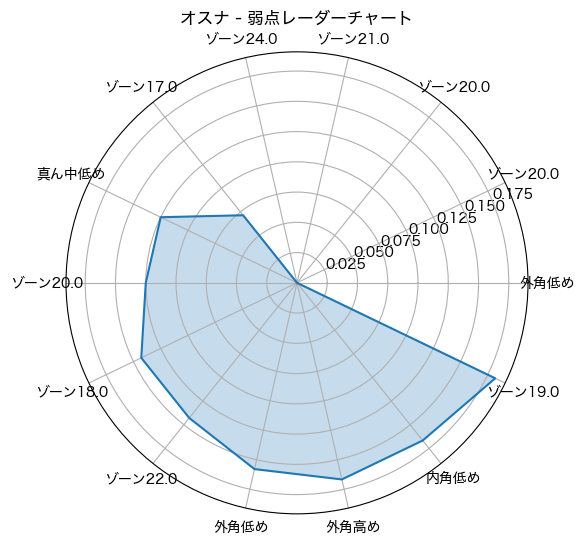

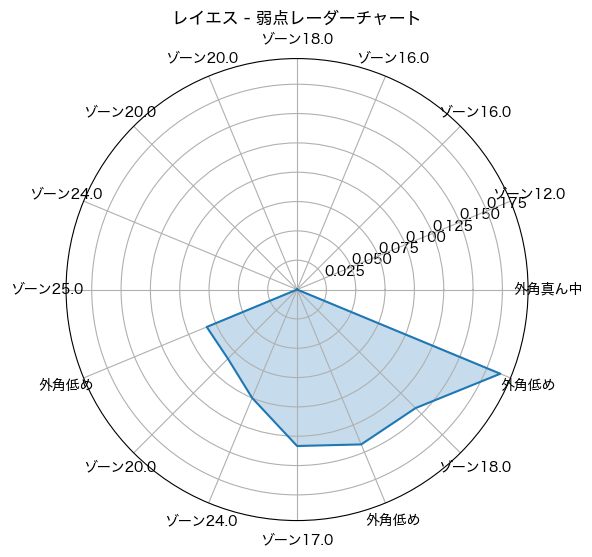

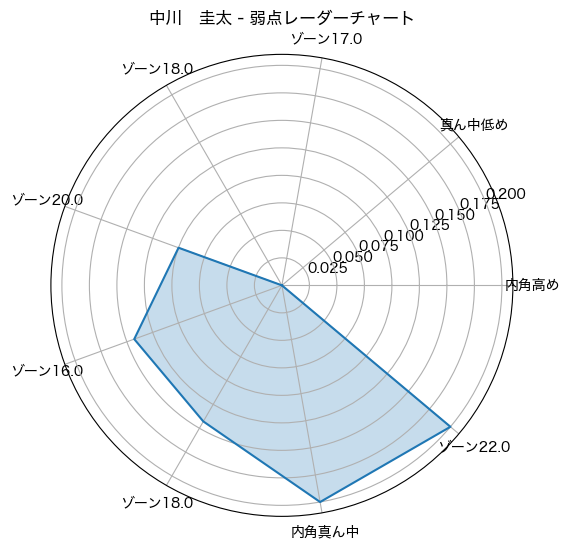

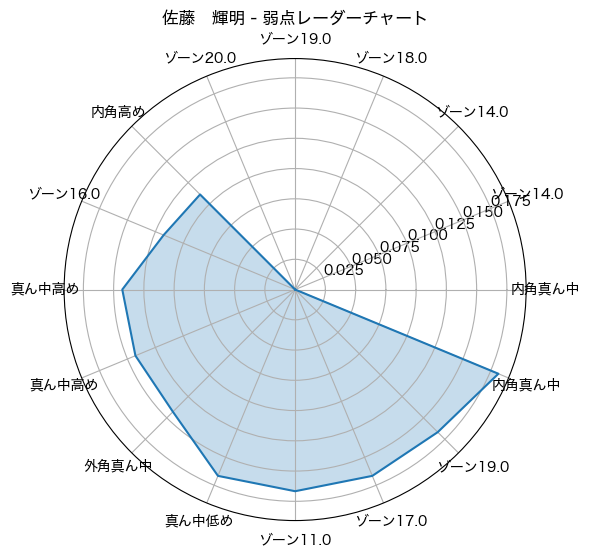

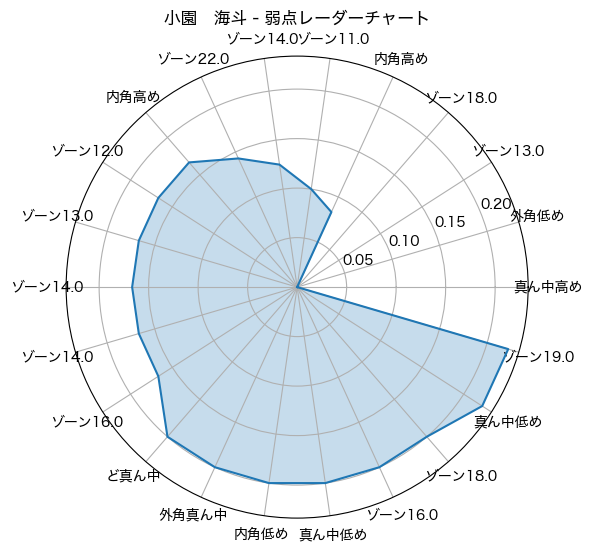

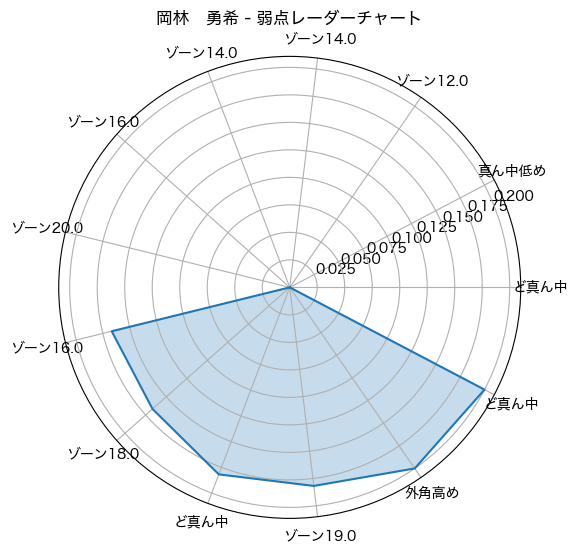

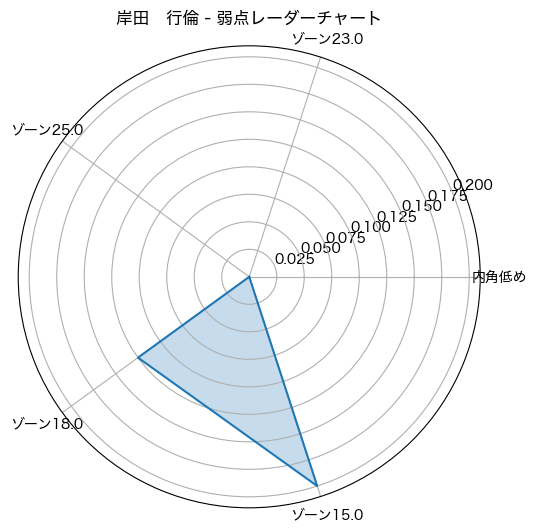

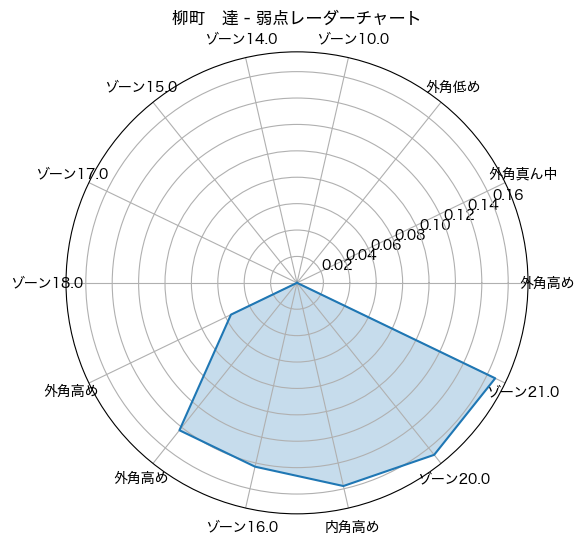

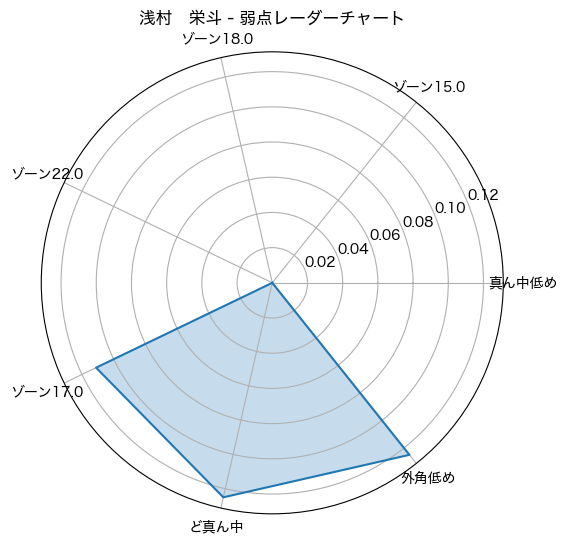

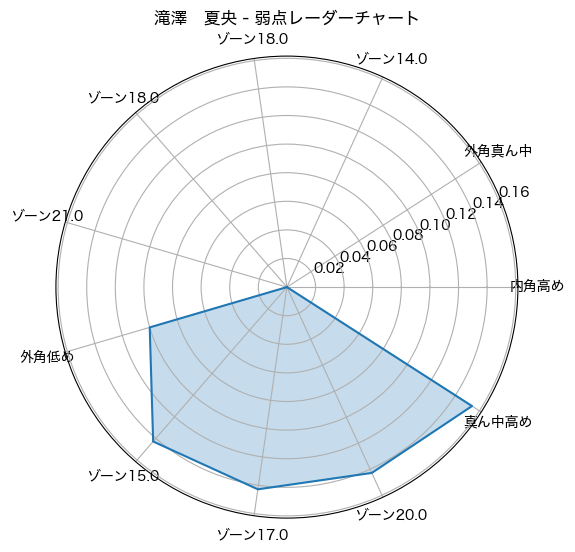

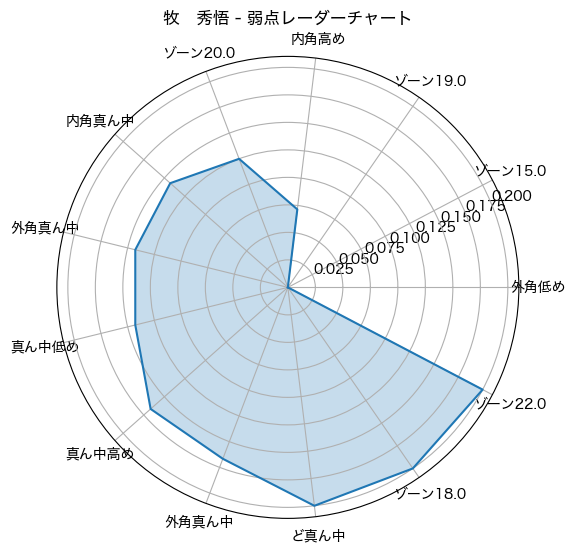

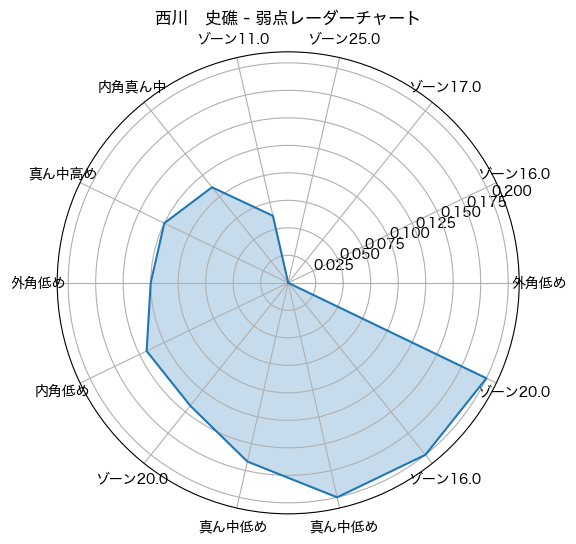

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Hiragino Sans'

# attack_list には weak のみが入っている仮定
# batter_name, zone_text, AVG_zone_pitch が必要

def plot_radar_for_batter(df, batter_name):
    sub = df[df["batter_name"] == batter_name]

    if len(sub) == 0:
        print(f"{batter_name} の weak データがありません")
        return

    # ラベル（ゾーン×球種ではなくゾーンのみ）
    labels = sub["zone_text"].tolist()
    values = sub["AVG_zone_pitch"].tolist()

    # レーダーチャート用に循環させる
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    # プロット
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    plt.title(f"{batter_name} - 弱点レーダーチャート")
    plt.show()


# ★ 全選手分 自動でレーダーチャートを描画
all_batters = attack_list["batter_name"].unique()

print("レーダーチャートを出力中…")

for batter in all_batters:
    plot_radar_for_batter(attack_list, batter)

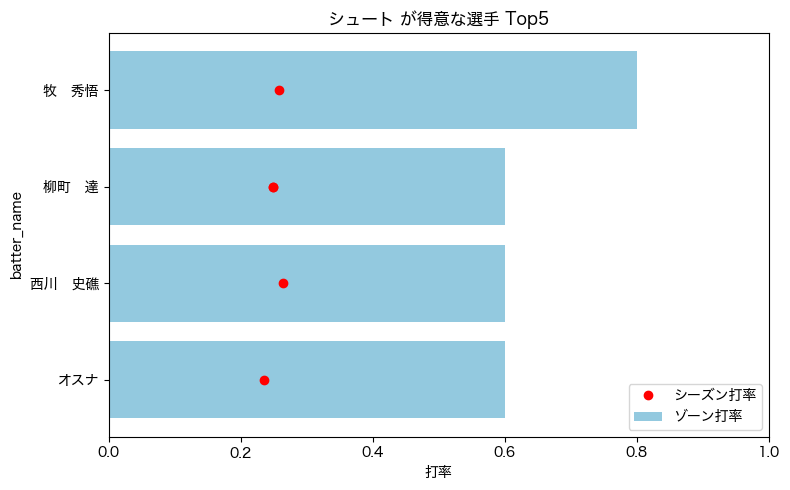

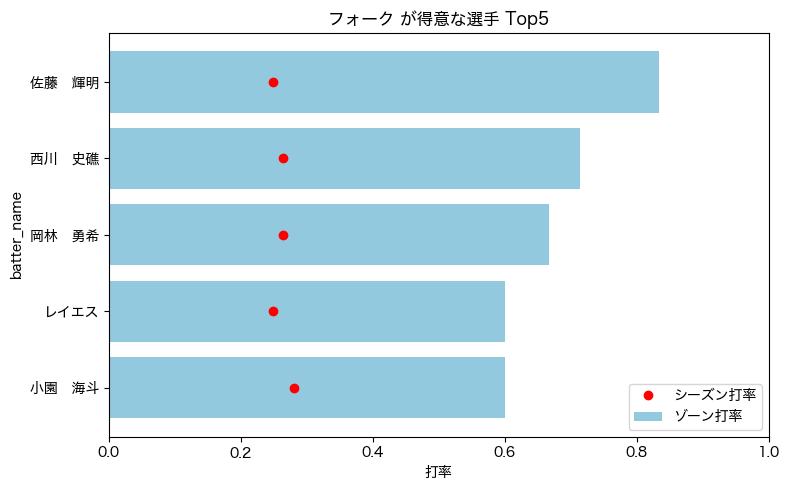

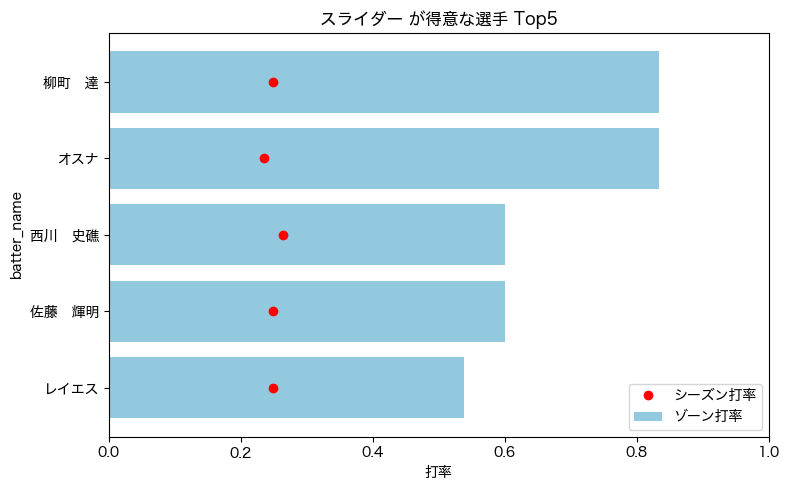

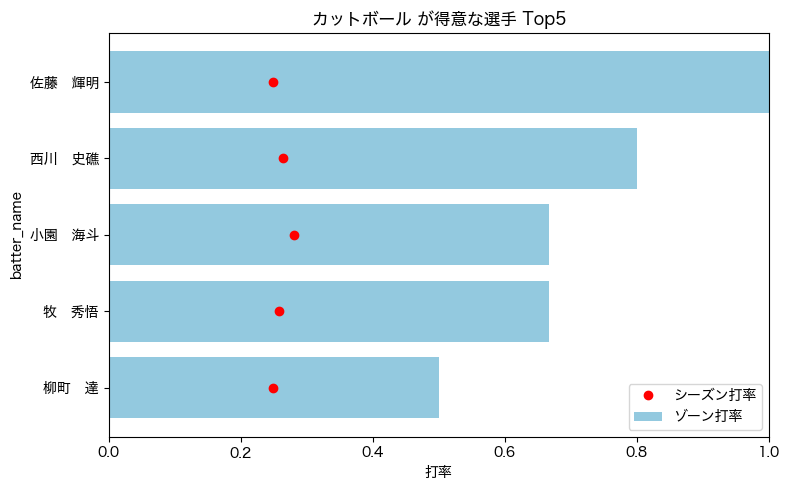

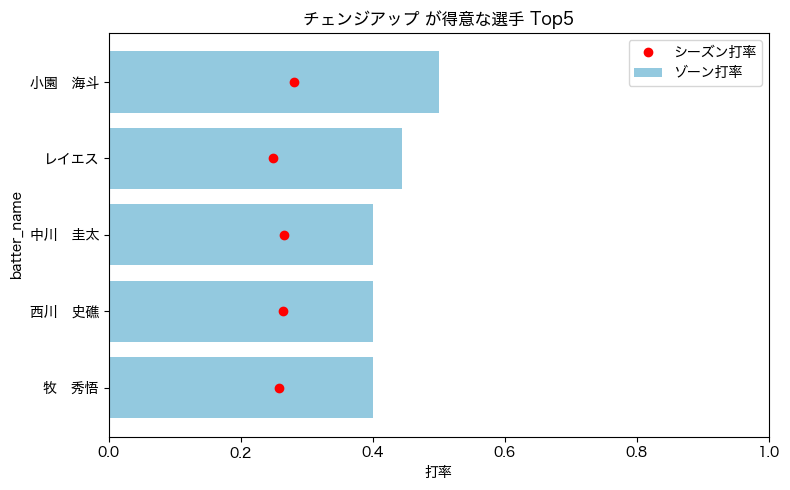

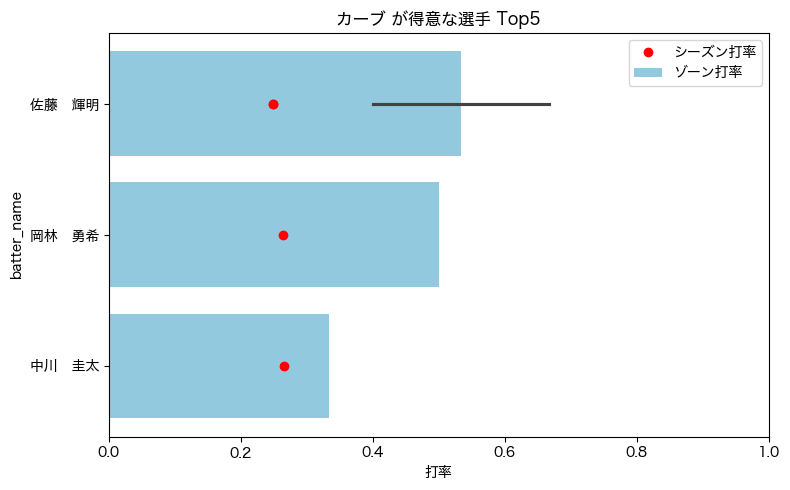

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ① 変化球だけ抽出（ストレート以外）
change_ball = merged[~merged["pitch_type_name"].str.contains("ストレート", na=False)]

# ② strong 判定（PA >= 5, AVG_zone_pitch がシーズンより +0.05 以上）
strong_df = change_ball[
    (change_ball["PA"] >= 5) &
    (change_ball["season_AVG"].notna()) &
    (change_ball["AVG_zone_pitch"] >= change_ball["season_AVG"] + 0.05)
].copy()

# ③ 球種ごとに Top5 を選択
topN = 5
for pitch_type in strong_df["pitch_type_name"].unique():
    sub = strong_df[strong_df["pitch_type_name"] == pitch_type].sort_values(
        "AVG_zone_pitch", ascending=False
    ).head(topN)

    if len(sub) == 0:
        continue

    # ④ グラフ描画
    plt.figure(figsize=(8,5))
    sns.barplot(
        x="AVG_zone_pitch",
        y="batter_name",
        data=sub,
        color="skyblue",
        label="ゾーン打率"
    )
    # シーズン打率を重ねて線で表示
    for i, row in sub.iterrows():
        plt.plot(row["season_AVG"], row["batter_name"], "ro", label="シーズン打率" if i==sub.index[0] else "")

    plt.title(f"{pitch_type} が得意な選手 Top{topN}")
    plt.xlabel("打率")
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()